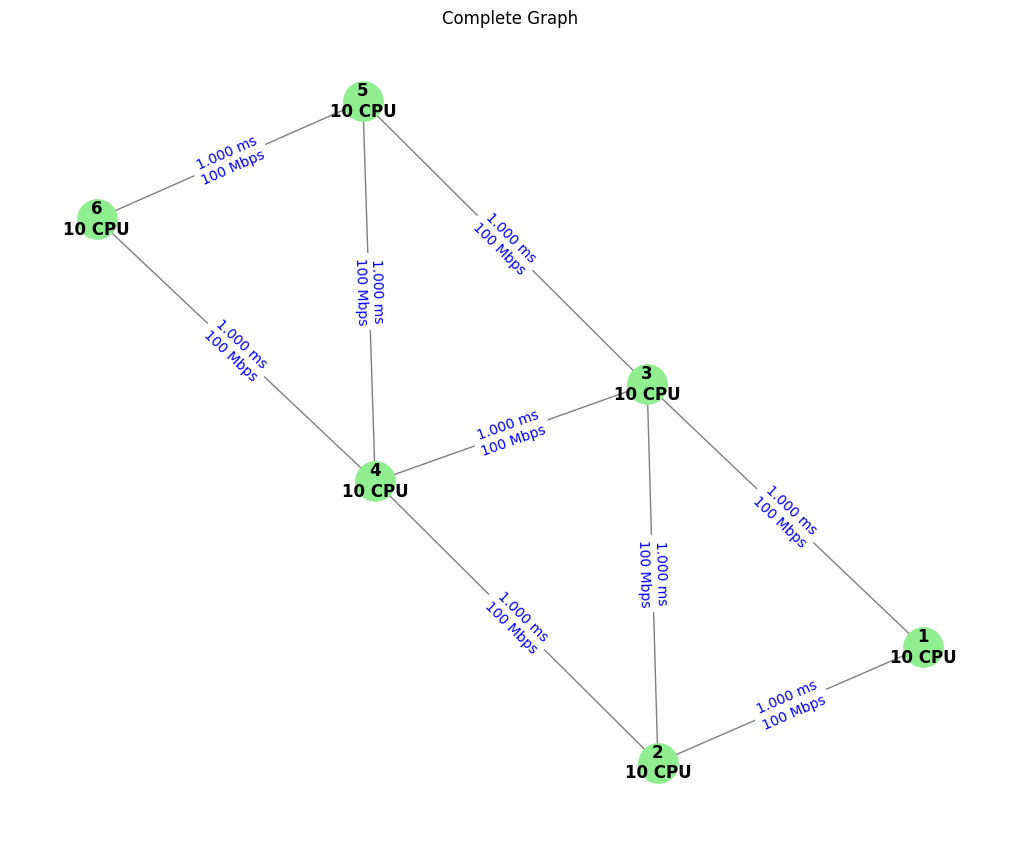

In [1]:
from topology import topology_bayern, draw_graph
from generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_pulp import solve_pulp      # <-- agora usamos pulp
from milp.adapter import MILPResultAdapterCBC

import pandas as pd

# === Topology ===
G = topology_bayern()
draw_graph(G)


In [2]:

# === Generate slices ===
vnf_profiles = [
    {"cpu": 2, "throughput": 50, "latency": 120},
    {"cpu": 4, "throughput": 20, "latency": 180},
    {"cpu": 6, "throughput": 60, "latency": 200},
]
slices = generate_random_slices(G, vnf_profiles, num_slices=3, num_vnfs_per_slice=2)

slices

[([{'id': 'vnf0_0', 'cpu': 2, 'throughput': 50, 'latency': 120, 'slice': 0},
   {'id': 'vnf0_1', 'cpu': 2, 'throughput': 50, 'latency': 120, 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 50, 'latency': 120}]),
 ([{'id': 'vnf1_0', 'cpu': 2, 'throughput': 50, 'latency': 120, 'slice': 1},
   {'id': 'vnf1_1', 'cpu': 4, 'throughput': 20, 'latency': 180, 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 50, 'latency': 120}]),
 ([{'id': 'vnf2_0', 'cpu': 4, 'throughput': 20, 'latency': 180, 'slice': 2},
   {'id': 'vnf2_1', 'cpu': 6, 'throughput': 60, 'latency': 200, 'slice': 2}],
  [{'from': 'vnf2_0', 'to': 'vnf2_1', 'bandwidth': 20, 'latency': 180}])]

In [3]:


# === Build MILP instance ===
instance = build_instance_from_topology(G, slices)

# === Solve MILP with CBC ===
res = solve_pulp(instance, msg=True)   # msg=False se não quiser log
print("Status:", res.status_str, " Objective:", res.objective)

# === Adapt to heuristic-like format ===
milp_result = MILPResultAdapterCBC(res, instance)
print(milp_result)
print("Placed VNFs:", milp_result.placed_vnfs)
print("Routed VLs:", milp_result.routed_vls)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ceciluz/projects/slicing/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/06ee48d424be4d11b4c20e14c93708bd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/06ee48d424be4d11b4c20e14c93708bd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 95 COLUMNS
At line 642 RHS
At line 733 BOUNDS
At line 827 ENDATA
Problem MODEL has 90 rows, 93 columns and 360 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4 - 0.00 seconds
Cgl0003I 6 fixed, 0 tightened bounds, 24 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 7 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 9 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tighte

In [4]:
def print_solution_pulp(res, instance, eps=1e-6):
    """
    Pretty-print MILP solution from PuLP + CBC result.
    Works with PulpSolveResult (res.values dict).
    """
    print("=== MILP Solution (CBC) ===")
    print(f"Objective value: {res.objective:.3f}")
    print(f"Status: {res.status_str}\n")

    vals = res.values

    # -------- VNF allocations (argmax over nodes) --------
    print("VNF allocations:")
    placed = {}
    for s in instance.S:
        for i in instance.V_of_s[s]:
            candidates = [(n, vals.get(("v", i, n), 0.0) or 0.0) for n in instance.N]
            n_star, v_star = max(candidates, key=lambda t: t[1])
            placed[i] = (n_star, v_star)
            print(f"  - {i} -> Node {n_star}  (value={v_star:.3f}, sum={sum(v for _,v in candidates):.3f})")

    # -------- Virtual Links (flows f[e,s,(i,j)]) --------
    print("\nVirtual Link allocations:")
    for s in instance.S:
        vnf_ids = instance.V_of_s[s]
        for q in range(len(vnf_ids)-1):
            i, j = vnf_ids[q], vnf_ids[q+1]
            used_edges = []
            for e in instance.E:
                val = vals.get(("f", e, s, (i, j)), 0.0) or 0.0
                if val > 0.5 - eps:
                    used_edges.append(e)
            if used_edges:
                print(f"  - Slice {s}, VL ({i}->{j}) uses edges: {used_edges}")
            else:
                print(f"  - Slice {s}, VL ({i}->{j}) NOT routed")

    # -------- Node utilization --------
    print("\nNode utilization:")
    for n in instance.N:
        u_val = vals.get(("u", n), 0.0) or 0.0
        z_val = vals.get(("z", n), 0.0) or 0.0
        print(f"  - Node {n}: u={u_val:.2f}, z={int(round(z_val))}")

    # -------- Link utilization --------
    print("\nLink utilization:")
    for e in instance.E:
        rho_val = vals.get(("rho", e), 0.0) or 0.0
        w_val = vals.get(("w", e), 0.0) or 0.0
        if rho_val > eps or w_val > 0.5 - eps:
            print(f"  - Link {e}: rho={rho_val:.2f}, w={int(round(w_val))}")





In [5]:
instance = build_instance_from_topology(G, slices)
res = solve_pulp(instance, msg=False)

print_solution_pulp(res, instance)

Total CPU demand: 20
Total CPU cap: 60
Total BW demand per slice: {0: 50, 1: 20, 2: 20}
Total BW cap: {(1, 2): 100, (1, 3): 100, (2, 3): 100, (2, 4): 100, (3, 4): 100, (3, 5): 100, (4, 5): 100, (4, 6): 100, (5, 6): 100}
Latency budgets: {0: 120, 1: 180, 2: 200}
=== MILP Solution (CBC) ===
Objective value: 7.900
Status: Optimal

VNF allocations:
  - vnf0_0 -> Node 3  (value=1.000, sum=1.000)
  - vnf0_1 -> Node 4  (value=1.000, sum=1.000)
  - vnf1_0 -> Node 3  (value=1.000, sum=1.000)
  - vnf1_1 -> Node 4  (value=1.000, sum=1.000)
  - vnf2_0 -> Node 4  (value=1.000, sum=1.000)
  - vnf2_1 -> Node 6  (value=1.000, sum=1.000)

Virtual Link allocations:
  - Slice 0, VL (vnf0_0->vnf0_1) uses edges: [(3, 4)]
  - Slice 1, VL (vnf1_0->vnf1_1) uses edges: [(3, 4)]
  - Slice 2, VL (vnf2_0->vnf2_1) uses edges: [(4, 6)]

Node utilization:
  - Node 1: u=0.00, z=0
  - Node 2: u=0.00, z=0
  - Node 3: u=0.40, z=1
  - Node 4: u=1.00, z=1
  - Node 5: u=0.00, z=0
  - Node 6: u=0.60, z=1

Link utilization:


In [6]:
print("Solver status:", res.status_str)
if res.status_str != "Optimal":
    print("⚠️ No feasible solution found.")


Solver status: Optimal


In [7]:
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})



In [8]:

from a_star import run_astar
from run_abo_full_batch import run_abo_full_batch
from run_fabo_full_batch import run_fabo_full_batch
from first_fit import run_first_fit
from best_fit import run_best_fit
from copy import deepcopy


In [9]:

df_astar, results_astar = run_astar(G, slices, node_capacity_base, link_capacity_base)
df_abo, abo_results = run_abo_full_batch(G, slices, node_capacity_base, link_latency ,link_capacity_base)
df_fabo, fabo_results = run_fabo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_ff, ff_results = run_first_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_bestfit, bestfit_results = run_best_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)


df_astar
df_abo
df_fabo
df_bestfit


[INFO][A*] === Solving slice 1 with 2 VNFs and 1 VLs ===
[INFO][A*] Placed vnf0_0 on node 1 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 2 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 3 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 4 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 5 (use=2, remaining=8).
[INFO][A*] Placed vnf0_0 on node 6 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 2 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 3 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 4 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 5 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 6 (use=2, remaining=8).
[DEBUG][A*] Anti-affinity: vnf0_1 cannot be placed on node 1 (another VNF of slice 0 already there).
[INFO][A*] Placed vnf0_1 on node 1 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 3 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 4 (use=2, remaining=8).
[INFO][A*] Placed vnf0_1 on node 5 (use=2, 

,slice,accepted,g_cost
0,1,True,1
1,2,True,1
2,3,True,1


In [10]:
from milp.solver_pulp import solve_pulp
from milp.adapter import MILPResultAdapterCBC

# monta a instância como antes
# instance = MILPInstance(G, slices)

res = solve_pulp(instance, msg=False)  # msg=True para ver o log do CBC
print("Status:", res.status_str, " Objective:", res.objective)

milp_result = MILPResultAdapterCBC(res, instance)

# integra nas métricas como se fosse mais um método
method_results = {
    "A*": results_astar,
    "ABO": abo_results,
    "FABO": fabo_results,
    "First Fit": ff_results,
    "Best-fit": bestfit_results,
    "MILP (CBC)": [milp_result],
}

# agora o teu loop de métricas (compute_energy_*) funciona direto


Total CPU demand: 20
Total CPU cap: 60
Total BW demand per slice: {0: 50, 1: 20, 2: 20}
Total BW cap: {(1, 2): 100, (1, 3): 100, (2, 3): 100, (2, 4): 100, (3, 4): 100, (3, 5): 100, (4, 5): 100, (4, 6): 100, (5, 6): 100}
Latency budgets: {0: 120, 1: 180, 2: 200}
Status: Optimal  Objective: 7.9


In [11]:
# All comments in English
import matplotlib.pyplot as plt
import networkx as nx

def plot_solution_pulp(G, res, instance):
    """
    Visualize MILP solution (PuLP + CBC).
    - Active nodes in green, inactive in gray
    - Node labels show VNFs placed
    - Active links highlighted in red
    """
    pos = nx.spring_layout(G, seed=42)
    vals = res.values

    # Collect VNFs per node
    vnfs_per_node = {n: [] for n in instance.N}
    active_nodes = set()
    for s in instance.S:
        for i in instance.V_of_s[s]:
            for n in instance.N:
                if vals.get(("v", i, n), 0.0) > 0.5:
                    vnfs_per_node[n].append(i)
    for n in instance.N:
        if vals.get(("z", n), 0.0) > 0.5:
            active_nodes.add(n)

    # Node colors
    node_colors = ["lightgreen" if n in active_nodes else "lightgray" for n in G.nodes()]

    # Draw base graph
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, node_size=800, with_labels=False)

    # Labels = node id + VNFs
    labels = {}
    for n in G.nodes():
        if vnfs_per_node[n]:
            labels[n] = f"{n}\n" + ",".join(vnfs_per_node[n])
        else:
            labels[n] = str(n)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    # Highlight active links
    active_edges = []
    for e in instance.E:
        if vals.get(("w", e), 0.0) > 0.5:
            active_edges.append(e)
    nx.draw_networkx_edges(G, pos, edgelist=active_edges, edge_color="red", width=2)

    plt.title("MILP Solution (CBC)")
    plt.show()


Total CPU demand: 20
Total CPU cap: 60
Total BW demand per slice: {0: 50, 1: 20, 2: 20}
Total BW cap: {(1, 2): 100, (1, 3): 100, (2, 3): 100, (2, 4): 100, (3, 4): 100, (3, 5): 100, (4, 5): 100, (4, 6): 100, (5, 6): 100}
Latency budgets: {0: 120, 1: 180, 2: 200}


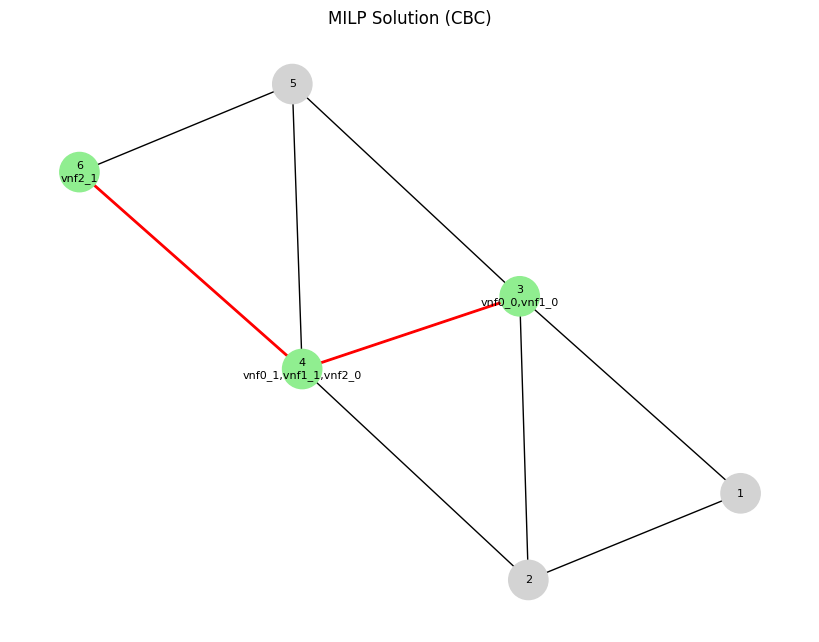

In [12]:
res = solve_pulp(instance, msg=False)
plot_solution_pulp(G, res, instance)


In [13]:
def _is_vl_routed(result, slice_idx, src, dst):
    """
    Check if a VL (src->dst) is routed in 'result', accepting different key styles:
    - (src, dst)
    - (dst, src)  # caso tenha sido salvo invertido
    - (slice_idx, (src, dst))
    - (slice_idx, (dst, src))
    And accept either a path (list of nodes) or a list of edges (u,v).
    """
    if not result or not getattr(result, "routed_vls", None):
        return False

    # direct keys (heurísticas)
    if (src, dst) in result.routed_vls:
        val = result.routed_vls[(src, dst)]
        return bool(val)  # non-empty path/edge list
    if (dst, src) in result.routed_vls:
        val = result.routed_vls[(dst, src)]
        return bool(val)

    # MILP adapter style
    key1 = (slice_idx, (src, dst))
    key2 = (slice_idx, (dst, src))
    if key1 in result.routed_vls:
        return bool(result.routed_vls[key1])
    if key2 in result.routed_vls:
        return bool(result.routed_vls[key2])

    return False




In [14]:
def count_accepted_slices(results, slices, eps=1e-6, verbose=True):
    """
    A slice is accepted iff:
      - all its VNFs are placed
      - all its VLs are routed
    With sanity check logging.
    """
    accepted = 0
    for s_idx, result in enumerate(results):
        if not result or not hasattr(result, "placed_vnfs") or not hasattr(result, "routed_vls"):
            if verbose:
                print(f"[Slice {s_idx}] REJECTED: result missing placed_vnfs/routed_vls")
            continue

        vnfs, vls = slices[s_idx]

        # --- Check VNFs
        placed_ok = all(v["id"] in result.placed_vnfs for v in vnfs)
        if not placed_ok:
            if verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in result.placed_vnfs]
                print(f"[Slice {s_idx}] REJECTED: missing VNFs {missing}")
            continue

        # --- Check VLs
        vls_ok = True
        for vl in vls:
            src, dst = vl["from"], vl["to"]

            if (src, dst) in result.routed_vls or (dst, src) in result.routed_vls:
                continue
            elif (s_idx, (src, dst)) in result.routed_vls or (s_idx, (dst, src)) in result.routed_vls:
                continue
            else:
                vls_ok = False
                if verbose:
                    print(f"[Slice {s_idx}] REJECTED: VL ({src}->{dst}) not routed")
                break

        if vls_ok:
            accepted += 1
            if verbose:
                print(f"[Slice {s_idx}] ACCEPTED ✓ (all VNFs placed, all VLs routed)")

    if verbose:
        print(f"\nTotal slices accepted: {accepted}/{len(slices)}")
    return accepted




In [15]:
print("=== Sanity check for all methods ===")
for method_name, result_list in method_results.items():
    if not result_list:
        continue
    print(f"\n--- {method_name} ---")
    count_accepted_slices(result_list, slices, verbose=True)



=== Sanity check for all methods ===

--- A* ---
[Slice 0] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 1] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 2] ACCEPTED ✓ (all VNFs placed, all VLs routed)

Total slices accepted: 3/3

--- ABO ---
[Slice 0] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 1] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 2] ACCEPTED ✓ (all VNFs placed, all VLs routed)

Total slices accepted: 3/3

--- FABO ---
[Slice 0] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 1] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 2] ACCEPTED ✓ (all VNFs placed, all VLs routed)

Total slices accepted: 3/3

--- First Fit ---
[Slice 0] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 1] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 2] ACCEPTED ✓ (all VNFs placed, all VLs routed)

Total slices accepted: 3/3

--- Best-fit ---
[Slice 0] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 1] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slic

In [22]:
def sanity_check_milp_pulp(res, instance, slices, eps=1e-6):
    print("=== Sanity check MILP (CBC/PuLP) ===")
    print(f"Objective value: {res.objective:.3f}")
    print(f"Status: {res.status_str}")

    var_dict = res.values  # dict: key pode ser string ou tuple

    # --- CPU usage per node ---
    cpu_used = {n: 0 for n in instance.N}
    for key, value in var_dict.items():
        if isinstance(key, tuple):
            if key[0] == "v" and value > 0.5:
                _, i, n = key
                cpu_used[n] += instance.CPU_i[i]
        elif isinstance(key, str) and key.startswith("v_") and value > 0.5:
            _, i, n = key.split("_")
            n = int(n.replace("node", "")) if "node" in n else int(n)
            cpu_used[n] += instance.CPU_i[i]

    print("\nNode CPU usage:")
    for n in instance.N:
        used = cpu_used[n]
        cap = instance.CPU_cap[n]
        warn = "⚠️" if used > cap else ""
        print(f"  Node {n}: used {used} / cap {cap} {warn}")

    # --- Slice acceptance check ---
    accepted = 0
    for s in instance.S:
        vnfs, vls = slices[s]
        ok = True
        print(f"\n[Slice {s}]")

        # VNFs
        for v in vnfs:
            i = v["id"]
            assigned_nodes = []
            for key, value in var_dict.items():
                if isinstance(key, tuple) and key[0] == "v" and value > 0.5 and key[1] == i:
                    assigned_nodes.append(key[2])
                elif isinstance(key, str) and key.startswith("v_") and value > 0.5 and i in key:
                    assigned_nodes.append(int(key.split("_")[-1]))
            if assigned_nodes:
                print(f"  VNF {i} -> {assigned_nodes}")
            else:
                print(f"  VNF {i} NOT allocated")
                ok = False

        # VLs
        for vl in vls:
            i, j = vl["from"], vl["to"]
            used_edges = []
            for key, value in var_dict.items():
                if isinstance(key, tuple) and key[0] == "f" and value > 0.5:
                    _, e, s_idx, (src, dst) = key
                    if s_idx == s and {src, dst} == {i, j}:
                        used_edges.append(e)
                elif isinstance(key, str) and key.startswith("f_") and value > 0.5 and f"_{i}_{j}" in key:
                    parts = key.split("_")
                    e = (int(parts[1]), int(parts[2]))
                    used_edges.append(e)
            if used_edges:
                print(f"  VL ({i}->{j}) routed via {used_edges}")
            else:
                print(f"  VL ({i}->{j}) NOT routed")
                ok = False

        if ok:
            print(f"  -> Slice {s} ACCEPTED ✓")
            accepted += 1
        else:
            print(f"  -> Slice {s} REJECTED ✗")

    print(f"\nTotal slices accepted: {accepted}/{len(instance.S)}")


In [20]:
print(type(res))
print(dir(res))


<class 'milp.solver_pulp.PulpSolveResult'>
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'objective', 'status_code', 'status_str', 'values']


In [23]:
sanity_check_milp_pulp(res, instance, slices)

=== Sanity check MILP (CBC/PuLP) ===
Objective value: 7.900
Status: Optimal

Node CPU usage:
  Node 1: used 0 / cap 10 
  Node 2: used 0 / cap 10 
  Node 3: used 4 / cap 10 
  Node 4: used 10 / cap 10 
  Node 5: used 0 / cap 10 
  Node 6: used 6 / cap 10 

[Slice 0]
  VNF vnf0_0 -> [3]
  VNF vnf0_1 -> [4]
  VL (vnf0_0->vnf0_1) routed via [(3, 4)]
  -> Slice 0 ACCEPTED ✓

[Slice 1]
  VNF vnf1_0 -> [3]
  VNF vnf1_1 -> [4]
  VL (vnf1_0->vnf1_1) routed via [(3, 4)]
  -> Slice 1 ACCEPTED ✓

[Slice 2]
  VNF vnf2_0 -> [4]
  VNF vnf2_1 -> [6]
  VL (vnf2_0->vnf2_1) routed via [(4, 6)]
  -> Slice 2 ACCEPTED ✓

Total slices accepted: 3/3


In [26]:
def count_accepted_slices(results, slices, eps=1e-6, verbose=False):
    """
    Count accepted slices:
      - All VNFs placed
      - All VLs routed

    Handles:
      (A) Heuristics -> list with one result per slice, each having .placed_vnfs/.routed_vls
      (B) MILP adapter aggregated -> single result with routed_vls keys like (s_idx, (src,dst))
      (C) Raw PuLP result (PulpSolveResult) -> single result with .values dict
    """
    if not results:
        return 0

    # --- Helper: check routed VL presence with multiple key styles
    def _vl_present(routed_vls, s_idx, src, dst):
        """Check several key conventions: (src,dst), (dst,src), (s,(src,dst)), (s,(dst,src))."""
        if (src, dst) in routed_vls or (dst, src) in routed_vls:
            return True
        key1 = (s_idx, (src, dst))
        key2 = (s_idx, (dst, src))
        return key1 in routed_vls or key2 in routed_vls

    # ----------------------
    # Case C: Raw PuLP result (has .values)
    # ----------------------
    r0 = results[0]
    if hasattr(r0, "values"):  # PulpSolveResult-like
        var_dict = r0.values
        accepted = 0
        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]

            # VNFs placed? (look for ('v', vnf_id, node) with value>0.5)
            vnfs_ok = True
            for v in vnfs:
                i = v["id"]
                assigned = any(
                    isinstance(k, tuple) and k[0] == "v" and k[1] == i and val > 0.5
                    for k, val in var_dict.items()
                )
                if not assigned:
                    vnfs_ok = False
                    if verbose:
                        print(f"[MILP raw] slice {s_idx}: VNF {i} not allocated")
                    break

            # VLs routed?
            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    routed = any(
                        isinstance(k, tuple)
                        and k[0] == "f"
                        and k[2] == s_idx
                        and set(k[3]) == {src, dst}
                        and val > 0.5
                        for k, val in var_dict.items()
                    )
                    if not routed:
                        vls_ok = False
                        if verbose:
                            print(f"[MILP raw] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP raw] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP raw): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case B: MILP adapter (single aggregated result)
    # ----------------------
    is_milp_adapter = (
        len(results) == 1
        and hasattr(r0, "routed_vls")
        and any(isinstance(k, tuple) and len(k) >= 2 and isinstance(k[0], int) for k in r0.routed_vls.keys())
    )
    if is_milp_adapter:
        accepted = 0
        # placed_vnfs no adapter costuma ser {vnf_id: node}
        placed_vnfs = getattr(r0, "placed_vnfs", {})
        routed_vls = getattr(r0, "routed_vls", {})

        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]

            vnfs_ok = all(v["id"] in placed_vnfs for v in vnfs)
            if not vnfs_ok and verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in placed_vnfs]
                print(f"[MILP adapter] slice {s_idx}: missing VNFs {missing}")

            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    if not _vl_present(routed_vls, s_idx, src, dst):
                        vls_ok = False
                        if verbose:
                            print(f"[MILP adapter] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP adapter] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP adapter): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case A: heuristics (list com um result por slice)
    # ----------------------
    accepted = 0
    for s_idx, result in enumerate(results):
        if not result or not hasattr(result, "placed_vnfs") or not hasattr(result, "routed_vls"):
            continue
        vnfs, vls = slices[s_idx]

        vnfs_ok = all(v["id"] in result.placed_vnfs for v in vnfs)
        if not vnfs_ok:
            if verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in result.placed_vnfs]
                print(f"[Heuristic] slice {s_idx}: missing VNFs {missing}")
            continue

        vls_ok = all(
            (vl["from"], vl["to"]) in result.routed_vls or (vl["to"], vl["from"]) in result.routed_vls
            for vl in vls
        )
        if not vls_ok and verbose:
            missing = [
                (vl["from"], vl["to"]) for vl in vls
                if (vl["from"], vl["to"]) not in result.routed_vls
                and (vl["to"], vl["from"]) not in result.routed_vls
            ]
            print(f"[Heuristic] slice {s_idx}: missing VLs {missing}")

        if vnfs_ok and vls_ok:
            accepted += 1
            if verbose:
                print(f"[Heuristic] slice {s_idx}: ACCEPTED ✓")

    if verbose:
        print(f"Total slices accepted (heuristics): {accepted}/{len(results)}")
    return accepted


In [27]:
from compute_energy import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_energy_new
)

comparison_rows = []
for method_name, result_list in method_results.items():
    if not result_list:
        continue

    energy_per_slice, _ = compute_energy_per_slice(result_list, slices, node_capacity_base)
    _, _ = compute_energy_per_node(result_list, slices, node_capacity_base)

    total_bw_list = compute_total_bandwidth(result_list, slices)
    total_lat_list = compute_total_latency(result_list, link_latency)
    sum_bw  = sum(b for b in total_bw_list if b is not None)
    sum_lat = sum(l for l in total_lat_list if l is not None)

    normalized_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)

    comparison_rows.append({
        "Method": method_name,
        "Slices Accepted": count_accepted_slices(result_list, slices, verbose=False),
        "Total Bandwidth": sum_bw,
        "Total Latency": sum_lat,
        "Total Energy": normalized_energy
    })

df_metrics = pd.DataFrame(comparison_rows).reset_index(drop=True)
display(df_metrics)


,Method,Slices Accepted,Total Bandwidth,Total Latency,Total Energy
0,A*,3,120,3,8.0
1,ABO,3,120,3,5.0
2,FABO,3,120,3,8.0
3,First Fit,3,120,3,5.0
4,Best-fit,3,120,3,4.0
5,MILP (CBC),3,50,6,5.0


In [ ]:
print("MILP routed_vls keys:", list(milp_result.routed_vls.keys()))


MILP routed_vls keys: [(0, ('vnf0_0', 'vnf0_1')), ('vnf0_0', 'vnf0_1'), (1, ('vnf1_0', 'vnf1_1')), ('vnf1_0', 'vnf1_1'), (2, ('vnf2_0', 'vnf2_1')), ('vnf2_0', 'vnf2_1')]


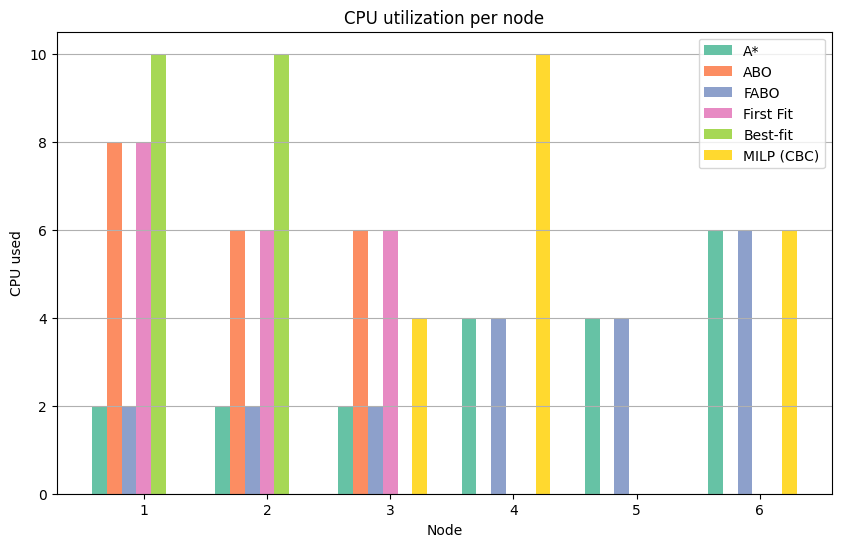

In [28]:
import matplotlib.pyplot as plt

node_capacity = {n: G.nodes[n]["cpu"] for n in G.nodes}
nodes = list(node_capacity.keys())

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.12
colors = plt.cm.Set2.colors

for idx, (method_name, result_list) in enumerate(method_results.items()):
    used_cpu = {n: 0 for n in nodes}
    for r in result_list:
        for vnf_id, n in r.placed_vnfs.items():
            # find CPU of this VNF
            vnf_cpu = next(vnf["cpu"] for s in slices for vnf in s[0] if vnf["id"] == vnf_id)
            used_cpu[n] += vnf_cpu
    usage = [used_cpu[n] for n in nodes]
    positions = [n + (idx - len(method_results)/2) * bar_width for n in nodes]
    ax.bar(positions, usage, width=bar_width, label=method_name, color=colors[idx % len(colors)])

ax.set_title("CPU utilization per node")
ax.set_xlabel("Node")
ax.set_ylabel("CPU used")
ax.set_xticks(nodes)
ax.legend()
plt.grid(axis="y")
plt.show()
